In [22]:
%matplotlib notebook
import os
import os.path as path
import numpy as np
import pandas as pd
import h5py
from scipy.optimize import curve_fit
from scipy import interpolate
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Local module and scripts
from pyccapt.calibration.calibration_tools import tools, data_tools, variables, data_loadcrop
from pyccapt.calibration.calibration_tools import widgets as wd
from pyccapt.calibration.mc import mc_tools
from pyccapt.calibration.leap_tools import apt_importers

# The initial value for flight path length, which is the distance of local electrod to detector 
flightPathLength = 110 # mm 
# The initial value for t_0
t0 = 51.74 # ns

# flightPathLength = 243 # 105.35 # mm 
# # The initial value for t_0
# t0 = 33 #68.48 # ns

analysis = False
save = True

In [2]:
# flightPathLength = 110 # mm 
# # The initial value for t_0
# t0 = 51.74 # ns

# dataset name
# AL_data_b
# OLO_AL_6_data
# OLO_W_6_data
# OLO_Ni_8_data
# X6Cr17_2V30Min_5_data
# data_1029_Jun-27-2022_15-53_Pd
# data_115_Jul-27-2022_17-44_Powersweep3

In [3]:
tdc, dataset, flightPathLength_d, t0_d = wd.dataset_tdc_selection()
display(tdc, dataset, flightPathLength_d, t0_d)

Dropdown(description='TDC model:', options=('surface_concept', 'roentdec'), value='surface_concept')

Text(value='OLO_AL_6_data', description='Dataset:', placeholder='Paste ticket description here!')

Text(value='110', description='Flight path length:', placeholder='Flight path length')

Text(value='51.74', description='t0:', placeholder='T_0 of the instrument')

$$\textbf{You can specify which dataset to use in below block}$$

In [32]:
tdc_model = tdc.value

dataset_name = dataset.value

flightPathLength = float(flightPathLength_d.value) # mm 
# The initial value for t_0
t0 = float(t0_d.value) # ns

p = path.abspath(path.join("", "../../../.."))

variables.init()

path_main = os.path.join(p, 'tests//data')
filename_main = path_main + '//' + dataset_name + '.h5'

variables.path = os.path.join(p, 'tests//results//load_crop')
variables.result_path = os.path.join(p, 'tests/results/leap_oxcart_mc_overlay/' + dataset_name)
if not os.path.isdir(variables.result_path):
        os.makedirs(variables.result_path, mode=0o777, exist_ok=True)
        
filename = variables.path + '//' + dataset_name + '//' + dataset_name + '_cropped' + '.h5'



head, tail = os.path.split(filename)
figname = os.path.splitext(tail)[0]

data = data_tools.read_hdf5_through_pandas(filename)


dld_highVoltage = data['dld/high_voltage'].to_numpy()
try:
    dld_pulseVoltage = data['dld/pulse_voltage'].to_numpy()
except:
    dld_pulseVoltage = data['dld/laser_intensity'].to_numpy()
dld_t = data['dld/t'].to_numpy()
dld_x = data['dld/x'].to_numpy()
dld_y = data['dld/y'].to_numpy()

In [52]:
df = pd.DataFrame(np.array(h5py.File(filename)['df']))

In [53]:
df

,0
0,axis0
1,axis1
2,block0_items
3,block0_values


In [17]:

mc_oxcart = pd.DataFrame(np.array(h5py.File(filename)['cropped_dld']['mc']))


In [28]:
pos = apt_importers.read_pos(variables.path + '//' + dataset_name + '//R76_18742-v01.pos')

987316096


In [5]:
data

,dld/high_voltage,dld/pulse_voltage,dld/start_counter,dld/t,dld/x,dld/y
0,5261.248047,5261.248047,9299.0,634.893066,5.985306,-22.763265
1,5261.248047,5261.248047,9551.0,467.893908,-3.629388,17.032653
2,5261.248047,5261.248047,10161.0,649.486890,-17.828571,23.973061
3,5261.248047,5261.248047,10358.0,646.016742,19.038367,20.980408
4,5261.248047,5261.248047,10581.0,632.588778,22.476735,-6.176327
...,...,...,...,...,...,...
1822981,5708.472656,5708.472656,26372.0,618.042960,-19.993469,-22.922449
1822982,5708.472656,5708.472656,26455.0,612.954324,13.180408,18.751837
1822983,5708.472656,5708.472656,26564.0,453.642984,-8.309388,20.725714
1822984,5708.472656,5708.472656,26777.0,605.561400,18.274286,11.111020


In [30]:
mc_oxcart

,0
0,27.541528
1,13.689926
2,27.161130
3,27.690093
4,27.289706
...,...
1821898,27.014439
1821899,27.177952
1821900,13.528326
1821901,26.740241


In [31]:
pos

,x,y,z,m/n (Da)
0,3.548493,-34.641857,-8.220280,27.069761
1,-18.084227,24.685980,-6.264853,27.007277
2,29.249836,-40.686264,-18.264599,27.055134
3,-34.321972,-12.333393,-9.068679,27.077887
4,12.440739,14.017586,-2.289117,26.979486
...,...,...,...,...
61707251,-16.044676,-24.468315,-118.636879,27.002506
61707252,-35.799614,-4.778799,-121.198616,27.029478
61707253,9.548644,25.599161,-118.021576,26.982464
61707254,8.407651,-36.134308,-121.616737,13.477153


In [34]:
arr_mc_oxcart = np.array(mc_oxcart)

09-12-2022 13:23:55 | INFO | Selected Mode = count
09-12-2022 13:23:55 | INFO | Selected Mode = count
09-12-2022 13:23:55 | INFO | Selected Mode = count
09-12-2022 13:23:55 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


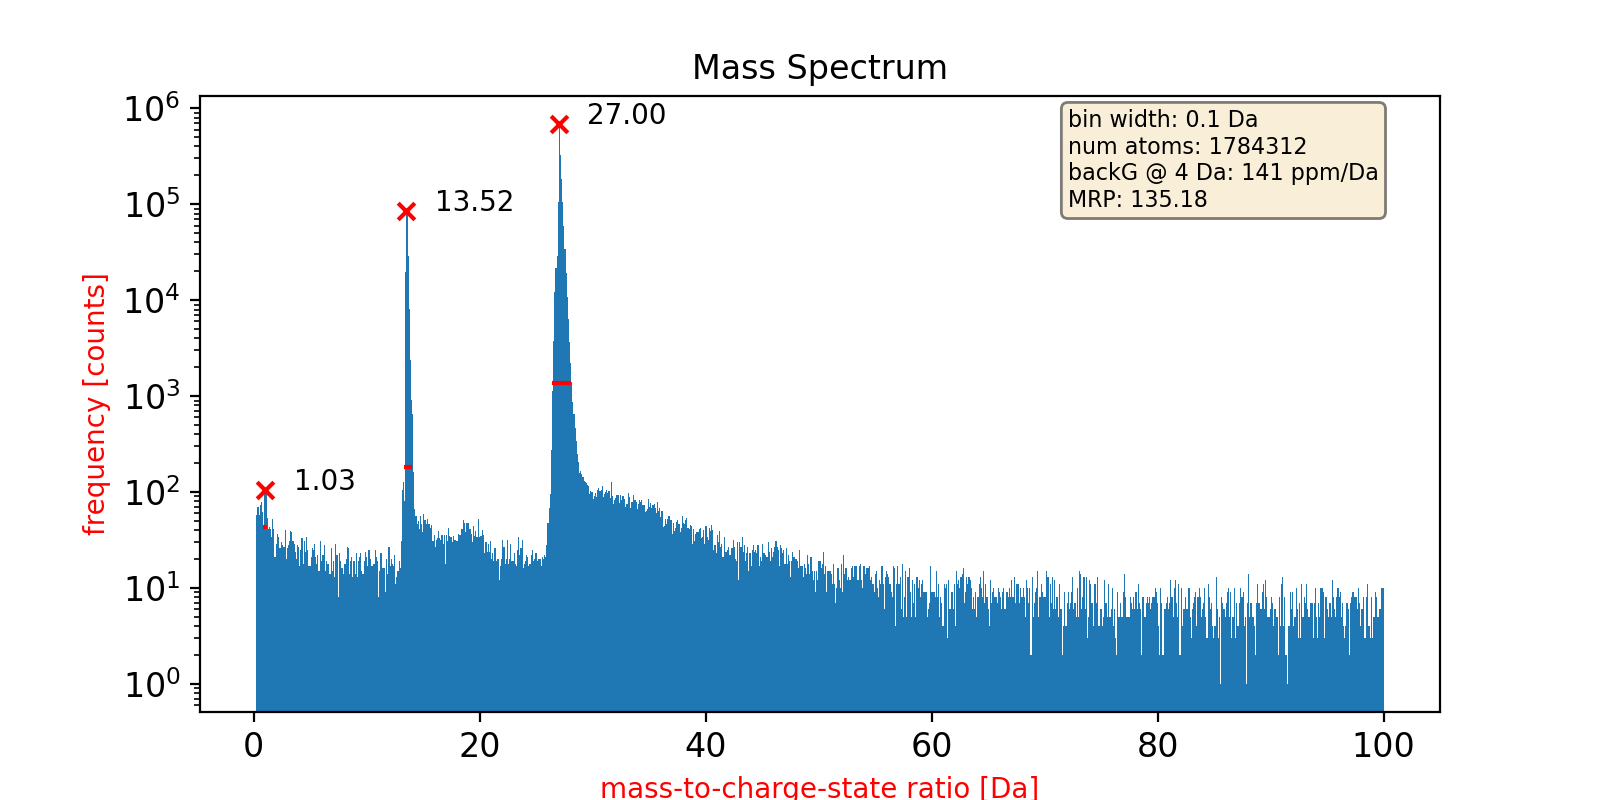

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): [135.17883945]
Peaks  0 is: 1.03 peak window sides are: 0.83 - 1.23
Peaks  1 is: 13.52 peak window sides are: 13.42 - 13.62
Peaks  2 is: 27.00 peak window sides are: 26.90 - 27.10


In [56]:
max_hist_p, left_right_peaks_p, peaks_sides_p, max_paek_edges_p, index_max_p = tools.massSpecPlot(arr_mc_oxcart[arr_mc_oxcart < 100], 0.1, prominence=50, distance=100, text_loc='right', percent=50, plot=True, fig_name='oxcart_mc_'+figname)
mrp = (max_hist_p / (left_right_peaks_p[1] - left_right_peaks_p[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides_p)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides_p[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides_p[i,2], peaks_sides_p[i,3]))

In [37]:
arr_mc_leap = np.array(pos['m/n (Da)'])

09-12-2022 13:23:44 | INFO | Selected Mode = count
09-12-2022 13:23:44 | INFO | Selected Mode = count
09-12-2022 13:23:44 | INFO | Selected Mode = count
09-12-2022 13:23:44 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


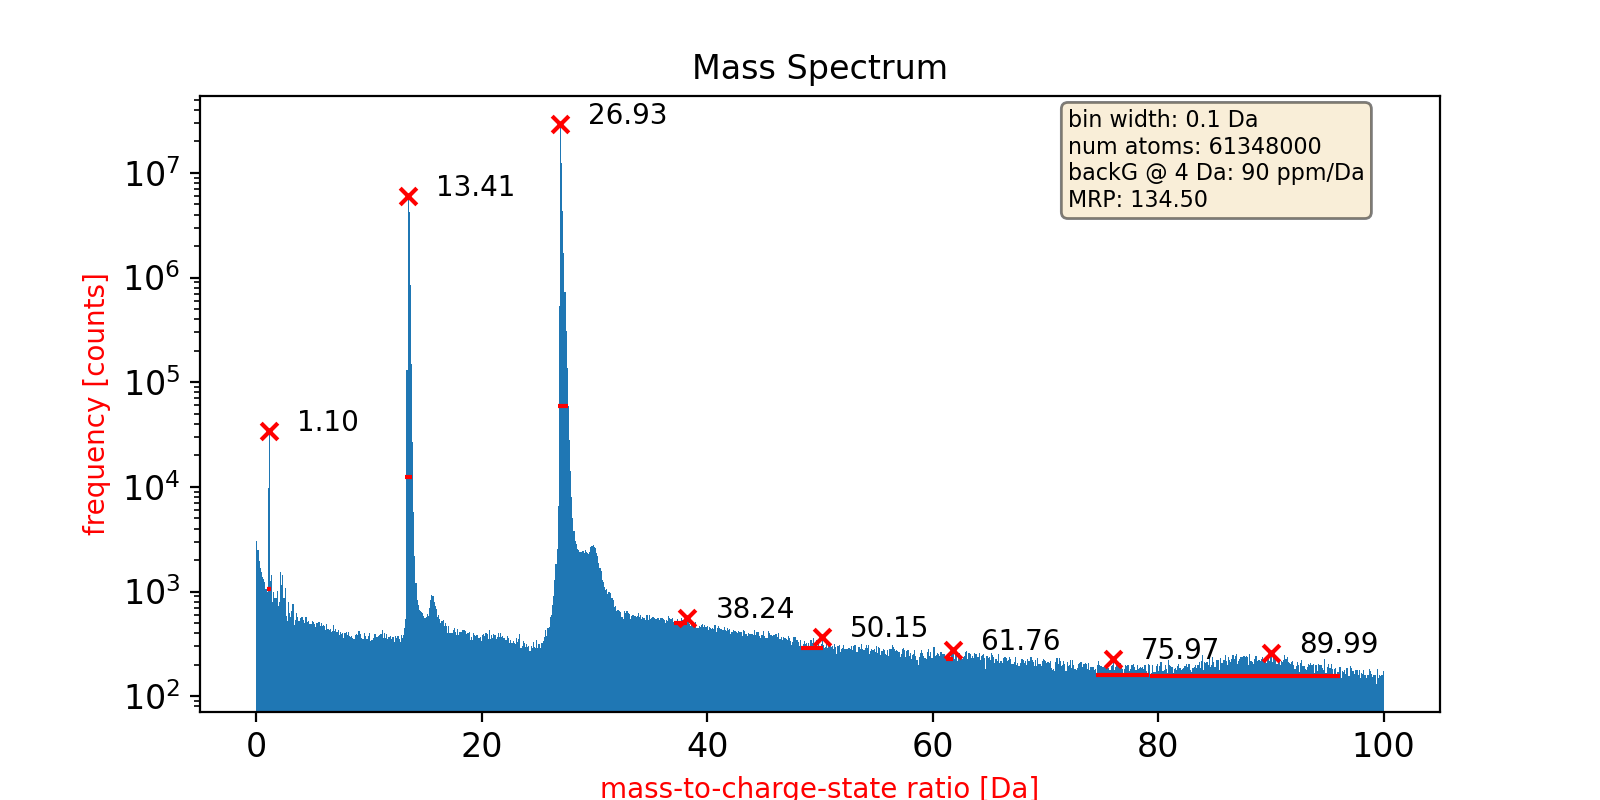

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): [134.5009178]
Peaks  0 is: 1.10 peak window sides are: 1.00 - 1.20
Peaks  1 is: 13.41 peak window sides are: 13.31 - 13.61
Peaks  2 is: 26.93 peak window sides are: 26.83 - 27.03
Peaks  3 is: 38.24 peak window sides are: 24.22 - 51.45
Peaks  4 is: 50.15 peak window sides are: 99.90 - 64.66
Peaks  5 is: 61.76 peak window sides are: 99.90 - 99.30
Peaks  6 is: 75.97 peak window sides are: 99.90 - 99.90
Peaks  7 is: 89.99 peak window sides are: 99.90 - 99.90


In [55]:
max_hist_p, left_right_peaks_p, peaks_sides_p, max_paek_edges_p, index_max_p = tools.massSpecPlot(arr_mc_leap[arr_mc_leap < 100], 0.1, prominence=50, distance=100, text_loc='right', percent=50, plot=True, fig_name='leap_mc_'+figname)
mrp = (max_hist_p / (left_right_peaks_p[1] - left_right_peaks_p[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides_p)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides_p[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides_p[i,2], peaks_sides_p[i,3]))

<IPython.core.display.Javascript object>


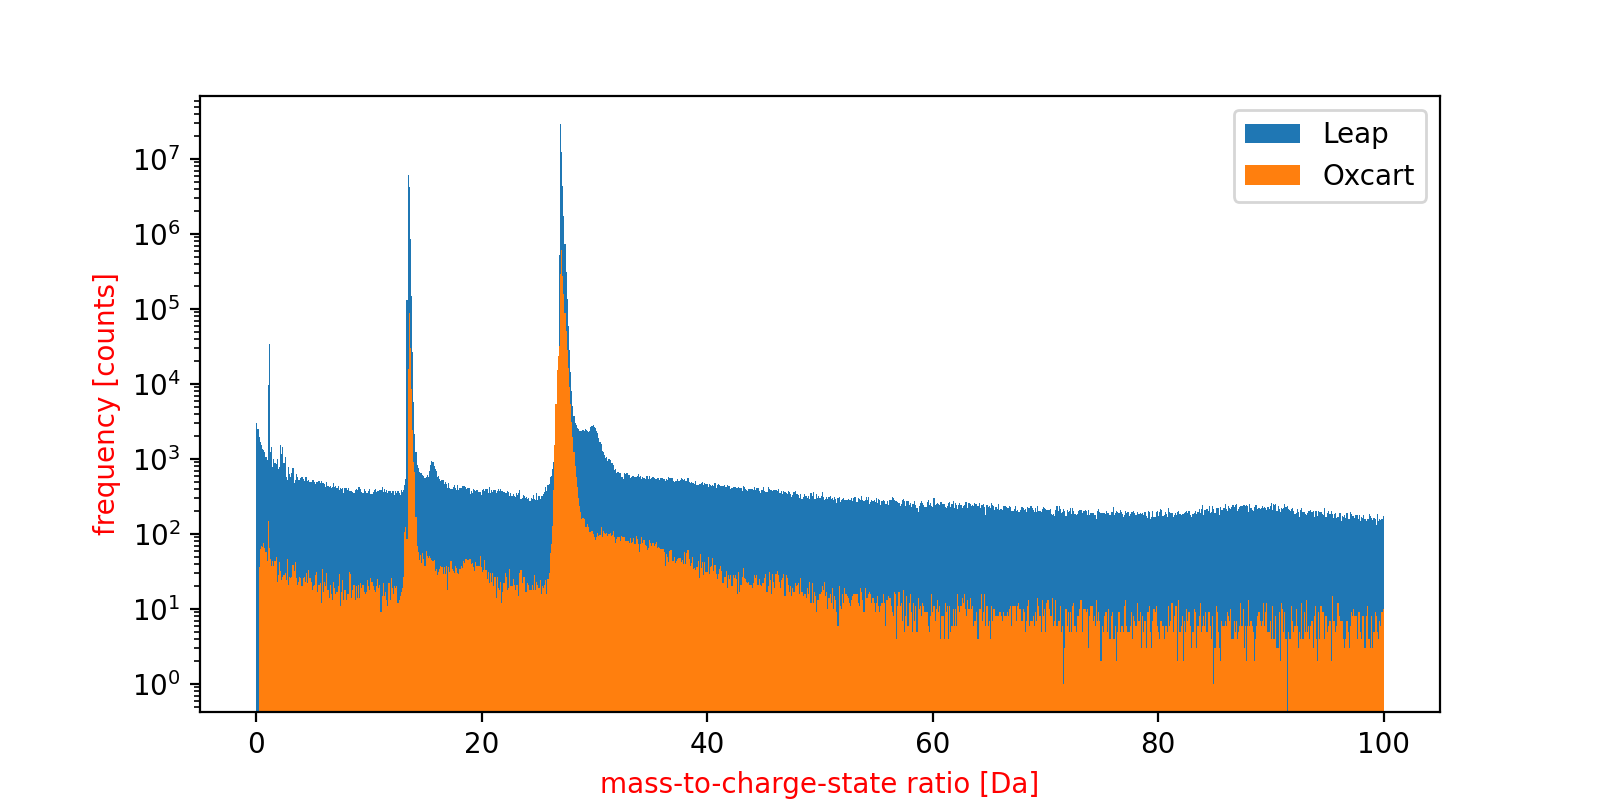

In [61]:
bin = 0.1
bins = np.linspace(np.min(arr_mc_leap[arr_mc_leap < 100]), np.max(arr_mc_leap[arr_mc_leap < 100]), round(np.max(arr_mc_leap[arr_mc_leap < 100]) / bin))


fig1, ax1 = plt.subplots(figsize=(8, 4))
l1 = plt.hist(arr_mc_leap[arr_mc_leap < 100], bins=bins, log=True, label='Leap')
l2 = plt.hist(arr_mc_oxcart[arr_mc_oxcart < 100], bins=bins, log=True, label='Oxcart')
ax1.set_xlabel("mass-to-charge-state ratio [Da]", color="red", fontsize=10)
ax1.set_ylabel("frequency [counts]", color="red", fontsize=10)
plt.legend(loc='upper right')
plt.show()
plt.savefig(variables.result_path + "//overlay_mc_%s.svg" % figname, format="svg", dpi=600)
plt.savefig(variables.result_path + "//overlay_mc_%s.png" % figname, format="png", dpi=600)